# **Ενδιάμεση Εργασία** / *Σωτήριος-Λουκάς Καμπύλης, <u>ΑΕΜ:3805</u>*

## Γενικές Οδηγίες (*για το Dataset της MNIST*):

Για τις ανάγκες αυτής της εργασίας χρησιμοποιήθηκε το σύνηθες *Dataset* της **MNIST** με τα *χειρόγραφα ψηφία*, το οποίο φορτώθηκε από το *keras*. Οι εικόνες αποτελούνται από **784 pixels** (ή αλλιώς **28x28**). Η βάση περιέχει **60.000** εικόνες χειρόγραφων ψηφίων με σκοπό την χρήση τους στην εκπαίδευση (*train*) και **10.000** για τον έλεγχο της ποιότητας της εκπαίδευσης (*test*). Επίσης, παρέχονται και οι αντίστοιχες ετικέτες (*labels*), οι οποίες υποδεικνύουν το ψηφίο το οποίο απεικονίζεται στην εκάστοτε εικόνα. Σκοπός και κύριος στόχος της συγκεκριμένης εργασίας είναι: η υλοποίηση (*from scratch*) της μεθόδου PCA και η σύγκριση της απόδοσης του *κατηγοριοποιητή πλησιέστερου γείτονα/KNN* (με 1 και 3 πλησιέστερους γείτονες) με τον *κατηγοριοποιητή πλησιέστερου κέντρου/NCC* στην βάση δεδομένων της MNIST.

# 1.Εισαγωγή, Φόρτωση & Επεξεργασία των Δεδομένων

## 1.1 Εισαγωγή Απαραίτητων Βιβλιοθηκών

Παρακάτω εισάγονται οι απαραίτητες βιβλιοθήκες για να τρέξει ο υπόλοιπος κώδικας. Αυτές κρίνονται απαραίτητες για τους αλγορίθμους των 2 κατηγοριοποιητών (*κατηγοριοποιητή πλησιέστερου γείτονα με 1 και 3 πλησιέστερους γείτονες* ή αλλιώς K-Nearest Neighbors, **KNN** / *κατηγοριοποιητή πλησιέστερου κέντρου* ή αλλιώς Nearest Class Centroid Method, **NCC**). Μάλιστα, χρησιμοποιείται η **timeit** για την καταγραφή χρόνου.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import timeit

from keras.datasets import mnist
from collections import Counter


## 1.2 Φόρτωση & Επεξεργασία Δεδομένων

Αρχικά, *φορτώνουμε* το σύνολο δεδομένων της **MNIST**. Ύστερα, *κανονικοποιούμε* τις τιμές φωτεινότητας μεταξύ **0** και **1** (από **0** και **255**) έτσι ώστε να δωθεί στα δεδομένα μία κοινή κατάσταση, δηλαδή όλες οι μεταβλητές να είναι κεντραρισμένες παρόμοια. Αυτή η διαδικασία κρίνεται εξαιρετικά σημαντική για την μειώση διαστάσεων με **PCA** (η οποία θα πραγματοποιηθεί στην συνέχεια). Μάλιστα, με την `astype('float32')` μετατρέπουμε το σύνολο δεδομένων σε *32 bit πραγματικούς*, διότι έτσι θα εφαρμοστεί καλύτερα στην *RAM*! Έπειτα ο πίνακας (όπου είναι αποθηκεύμενες αυτές οι τιμές για τα train/test δεδομένα) μετατρέπεται απο *τρισδιάστατος* σε *δισδιάστατος*, κάνοντας τις διαστάσεις **28x28** (δηλαδή **784**).

In [2]:
# Φορτώνουμε το σύνολο δεδομένων της MNIST
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()


11490434/11490434 [==============================] - 2s 0us/step


In [3]:
# Κανονικοποιούμε τα δεδομένα μεταξύ 0 και 1 (από 0 και 255)
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')
train_data = train_data / 255.0
test_data = test_data / 255.0
# Μετατρέπω τα train_data/test_data από τρισδιάστατο πίνακα (60000, 28, 28) 
# σε δισδιάστατο πίνακα (60000, 784)
num_pixels = 784
train_data = train_data.reshape(train_data.shape[0], num_pixels)
test_data = test_data.reshape(test_data.shape[0], num_pixels)

# Εκτυπώνω τις τιμές έτσι ώστε να δω πως όλα πήγαν καλά!
print("Train/test data shape:", train_data.shape, test_data.shape)
print("Train/test labels shape:", train_labels.shape, test_labels.shape)


Train/test data shape: (60000, 784) (10000, 784)
Train/test labels shape: (60000,) (10000,)


# 2 Ανάλυση Κύριων Συνιστωσών (*PCA*)

# 2.1 Συνάρτηση PCA

Παρακάτω *δημιουργούμε* την συνάρτηση για να εφαρμόσουμε μείωση διαστάσεων στις χειρόγραφες εικόνες με τη χρήση της *Μεθόδου Ανάλυσης Πρωτευουσών Συνιστωσών* (**Principal Component Analysis** ή αλλίως **PCA**). Αρχικά, αφαιρείται ο αριθμητικός μέσος όλων των γραμμών από κάθε γραμμή, έτσι ώστε να κανονικοποιήσουμε τις μεταβλητές. Έπειτα, υπολογίζουμε τον πίνακα συνδιακύμανσης (*covariance matrix*), ώστε να κατανοήσουμε πως οι μεταβλητές ποικίλουν η μία με την άλλη από τον αριθμητικό μέσο και να δούμε αν υπάρχει μεταξύ τους κάποια σχέση. Ο πίνακας αυτός είναι συμμετρικός και έχει σαν καταχωρήσεις τις συνδιακυμάνσεις που σχετίζονται με όλα τα πιθανά ζευγάρια των αρχικών μεταβλητών. Η κύρια διαγώνιος ουσιαστικά περιέχει τη διασπορά όλων των μεταβλητών και επειδή οι καταχωρήσεις είναι συμμετρικές ως προς την κύρια διαγώνιο, ο άνω και κάτω τριγωνικός πίνακας είναι ίσοι. Το πρόσημο του πίνακα μας δείχνει πως σχετίζονται οι μεταβλητές μεταξύ τους. Μετέπειτα, υπολογίζονται οι ιδιοτιμές και τα ιδιοδιανύσματα του πίνακα συνδιασποράς, ώστε να οριστούν οι κύριες συνιστώσες. Τα ιδιοδιανύσματα του πίνακα ουσιαστικά αποτελούν τις κατευθύνσεις των αξόνων όπου υπάρχει η περισσότερη διασπορά, δηλαδή η περισσότερη πληροφορία, και οι ιδιοτιμές είναι οι συντελεστές των διανυσμάτων. Οπότε, ταξινομούμε με φθίνουσα σειρά τα ιδιοδιανύσματα με βάση τις ιδιοτιμές τους και έτσι παίρνουμε τις κύριες συνιστώσες με βάση τη σημαντικότητα τους. Έτσι, απο αυτές κρατάμε όποιες επιθυμούμε απο τις πρώτες. Aυτό το βήμα αποτελεί τον υπολογισμό του feature vector (πίνακα χαρακτηριστικών). Τέλος, πρέπει να προβάλλουμε τα δεδομένα στον άξονα των κυριών συνιστωσών, πολλαπλασιάζοντας τον πίνακα των αρχικών δεδομένων με τον πίνακα χαρακτηριστικών. Όσον αφορά το y, αφαιρείται από αυτό τον αριθμητικό μέσο του x και στη συνέχεια προλλαπλασιάζουμε τον πίνακα χαρακτηριστικών με τον πίνακα του y.

In [4]:
# Συνάρτηση που πραγματοποιεί την Ανάλυση Κύριων Συνιστωσών (PCA).
# x = train_data
# y = test_data
# d = Διαστάσεις στις οποίες θα μειωθούν τα train_data
def PCA(x, y, d):
    # Εύρεση του αριθμητικού μέσου στον πίνακα x
    x_mean = np.mean(x, axis=0)
    # Αφαίρεση του αριθμητικού μέσου όλων των γραμμών από κάθε γραμμή (για κανονικοποίηση)
    x = x - x_mean
    # Υπολογισμός Πίνακα Συνδιακύμανσης (ΠΡΟΣΟΧΗ: Θέλει Ανάστροφο Πίνακα γιατί η 
    # συνάρτηση cov() έχει τα χαρακτηριστικά στις στήλες και τα δείγματα στις γραμμές!)
    cov = np.cov(x.T)
    # Υπολογισμός Ιδιοτιμών και Ιδιοδιανυσμάτων του Πίνακα Συνδιακύμανσης
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    # Υπολογισμός Ανάστροφων Ιδιοδιανυσμάτων (γιατί από συνάρτηση linalg.eig() 
    # επιστράφηκε ως Διάνυσμα Στήλης και όχι ως Ιδιοδιάνυσμα, v[:,i])
    eigenvectors = eigenvectors.T
    # Δεικτοδότηση των ταξινόμημένων Ιδιοτιμών σε φθίνουσα σειρά
    indexes = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[indexes]
    eigenvectors = eigenvectors[indexes]
    # Υπολογισμός του νέου πίνακα x, ο οποίος κρατάει τις d πιο σημαντικές τιμές
    # του Ιδιοδιανύσματος
    new_x = eigenvectors[0:d]
    # Αφαίρεση του αριθμητικού μέσου και από τον πίνακα y
    y = y - x_mean
    # Προβολή του Ιδιοδιανύσματος μέσα στον χώρο του x (εφόσον αναστρέψουμε πάλι
    # το x!)
    pca_train = np.dot(x, new_x.T)
    # Προβολή του Ιδιοδιανύσματος μέσα στον χώρο του y (εφόσον αναστρέψουμε πάλι
    # το y!)
    pca_test = np.dot(y, new_x.T)
    return pca_train, pca_test


Κάνοντας χρήση της συγκεκριμένης μεθόδου τα χαρακτηριστικά ενός δείγματος μπορούν να μειωθούν από 784 σε **οποιοδήποτε αριθμό μικρότερο του 784**. Η επιλογή που κάνω είναι οι *25 κύριες συνιστώσες*!

In [5]:
# Επιστροφή των δεδομένων μέσα από την συνάρτηση PCA (δηλαδή τις προβολές των
# Ιδιοδιανυσμάτων για το pca & το pca_test)
new_train_data, new_test_data = PCA(train_data, test_data, 25)

# Εκτυπώνω τις τιμές έτσι ώστε να δω πως όλα πήγαν καλά!
print("Train/test data shape:", new_train_data.shape, new_test_data.shape)


Train/test data shape: (60000, 25) (10000, 25)


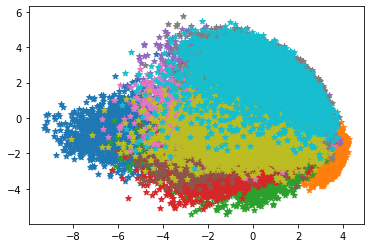

In [6]:
# Οπτικοποίηση των δεδομένων μετά από την χρήση της μεθόδου PCA
# Οι πίνακες T είναι πίνακες αληθείας που αναπαριστούν κάθε χειρόγραφο ψηφίο του Dataset
T0 = train_labels == 0
T1 = train_labels == 1
T2 = train_labels == 2
T3 = train_labels == 3
T4 = train_labels == 4
T5 = train_labels == 5
T6 = train_labels == 6
T7 = train_labels == 7
T8 = train_labels == 8
T9 = train_labels == 9

# Τοποθέτηση των γραμμών κάθε πίνακα T σε έναν άλλο πίνακα (για την επαλήθευση του Dataset
# και την οπτικοποίηση του)
M0 = new_train_data[T0 == 1, :]
M1 = new_train_data[T1 == 1, :]
M2 = new_train_data[T2 == 1, :]
M3 = new_train_data[T3 == 1, :]
M4 = new_train_data[T4 == 1, :]
M5 = new_train_data[T5 == 1, :]
M6 = new_train_data[T6 == 1, :]
M7 = new_train_data[T7 == 1, :]
M8 = new_train_data[T8 == 1, :]
M9 = new_train_data[T9 == 1, :]

# Εξαγωγή μόνο του πραγματικού μέρους του Ιδιοδιανύσματος
NM0 = M0.real
NM1 = M1.real
NM2 = M2.real
NM3 = M3.real
NM4 = M4.real
NM5 = M5.real
NM6 = M6.real
NM7 = M7.real
NM8 = M8.real
NM9 = M9.real

# Σχεδίαση των δεδομένων σε μια γραφική αναπαράσταση
plt.scatter(NM0[:, 0], NM0[:, 1], marker="*")
plt.scatter(NM1[:, 0], NM1[:, 1], marker="*")
plt.scatter(NM2[:, 0], NM2[:, 1], marker="*")
plt.scatter(NM3[:, 0], NM3[:, 1], marker="*")
plt.scatter(NM4[:, 0], NM4[:, 1], marker="*")
plt.scatter(NM5[:, 0], NM5[:, 1], marker="*")
plt.scatter(NM6[:, 0], NM6[:, 1], marker="*")
plt.scatter(NM7[:, 0], NM7[:, 1], marker="*")
plt.scatter(NM8[:, 0], NM8[:, 1], marker="*")
plt.scatter(NM9[:, 0], NM9[:, 1], marker="*")
plt.show()


# 3 Χρήσιμες Μετρικές & Υλοποίηση/Σύκριση των 2 κατηγοριοποιητών.

## 3.1 Δημιουργία (*from scratch*) των 2 μετρικών που θα χρησιμοποιηθούν για την σύγκριση των 2 κατηγοριοποιητών (**KNN/NCC**).

Επιλέγονται οι: α)*Μετρική της Ευκλείδειας Απόστασης* & η β)*Μετρική της Ακρίβειας*! Μάλιστα, μειώνεται το Dataset (γιατί αργούν πολύ οι κατηγοριοποιητές με όλο το Dataset!).

In [7]:
# Συνάρτηση που υπολογίζει την Ευκλείδεια Απόσταση
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

# Συνάρτηση που υπολογίζει την Ακρίβεια
def accuracy(y_true, y_pred):
    acc = np.sum(y_true == y_pred) / len(y_true)
    return acc

# Μείωση του Dataset στις πρώτες 7500 γραμμές και 800 στήλες
second_new_train_data = new_train_data[:7500, :]
second_new_test_data = new_test_data[:800, :]
new_train_labels = train_labels[:7500]
new_test_labels = test_labels[:800]


## 3.2 Κατηγοριοποιητής Κ Πλησιέστερων Γειτόνων (**KNN** *from scratch*)

Ο Κατηγοριοποιητής Πλησιέστερων Γειτόνων είναι μία ιδιαίτερα διαδεδομένη επιβλεπόμενη μέθοδος. Αρχικά, ο αλγόριθμος δέχεται ως είσοδο τα σημεία τα οποία πρέπει να χρησιμοποιήσει για να λάβει μια μελλοντική απόφαση κατηγοριοποίησης, τις ετικέτες αυτών των σημείων, την παράμετρο Κ, καθώς και τα σημεία που καλείται να κατηγοριοποιήσει. Η παράμετρος Κ που αναφέρθηκε προηγουμένως καθορίζει το πλήθος των σημείων που εν τέλει θα επηρεάσουν την απόφαση που θα ληφθεί για ένα καινούργιο σημείο προς κατηγοριοποίηση. Η γενική ιδέα του κατηγοριοποιητή αυτού είναι η προσπάθεια να εκμεταλλευτεί την τοπικότητα η οποία χαρακτηρίζει τα δείγματα που ανήκουν στην ίδια κλάση για το εκάστοτε πρόβλημα, δηλαδή βασίζεται στο όσο πιο κοντά είναι τα σημεία θα είναι και τόσο πιο όμοια! Δεδομένου κάποιου συγκεκριμένου Κ (στην περίπτωσή μας 1 ή 3) υπολογίζονται οι αποστάσεις μεταξύ ενός δοσμένου σημείου και των σημείων του συνόλου δεδομένων, ταξινομούνται με φθίνουσα σειρά και παίρνονται οι ετικέτες των πρώτων Κ καταχωρήσεων. Τέλος, επιστρέφεται η πρόβλεψη για το σημείο αυτό. Όσον αφορά την απόσταση, χρησιμοποιείται η Ευκλείδια Απόσταση.


In [8]:
# Κλάση του Κατηγοριοποιητή Κ Πλησιέστερων Γειτόνων
class KNN:

    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        # Υπολογισμός των αποστάσεων μεταξύ των x και όλων των παραδειγμάτων στο x_train
        # μέσω της Ευκλείδειας απόστασης
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        # Ταξινόμηση μέσα από τις αποστάσεις και επιστροφή των δεικτών από τους k
        # κοντινότερους γείτονες
        k_idx = np.argsort(distances)[:self.k]
        # Εύρεση ετικετών των k κοντινότερων γειτόνων του y_train
        k_neighbor_labels = [self.y_train[i] for i in k_idx]
        # Επιστροφή της πιο κοινής ετικέτας μιας κλάσης (από τα χειρόγραφα ψηφία)
        most_common = Counter(k_neighbor_labels).most_common(1)
        return most_common[0][0]


## 3.3 Κατηγοριοποιητής Πλησιέστερου Κέντρου (**NCC** *from scratch*)

Ο Κατηγοριοποιητής Πλησιέστερου Κέντρου είναι μια μέθοδος που μοιάζει πολύ σε λογική με αυτή των Κ-μέσων. Ο αλγόριθμος δέχεται ως είσοδο τα σημεία τα οποία πρέπει να χρησιμοποιήσει για να λάβει μια μελλοντική απόφαση κατηγοριοποίησης, τις ετικέτες αυτών των σημείων, καθώς και τα σημεία που καλείται να κατηγοριοποιήσει. Η γενική ιδέα του κατηγοριοποιητή αυτού είναι η δημιουργία ενός κύκλου γύρω από κάθε κλάση ο οποίος έχει ως κέντρο του εχει το διάνυσμα με τις μέσες τιμές για κάθε χαρακτηριστικό του συνόλου των σημείων που συμμετέχουν στην κλάση αυτή, δηλαδή βασίζεται στο ότι δεδομένου ενός σημείου, του δίνει μία ετικέτα από τα δεδομένα εκπαίδευσης, ανάλογα με το ποιο κέντρο αυτών είναι κοντά του. Το κέντρο κάθε κλάσης υπολογίζεται στην εκπαίδευση. Μετά, δεδομένου ενός σημείου υπολογίζονται οι αποστάσεις από αυτό σε κάθε κέντρο κλάσης. Από όλες τις αποστάσεις επιλέγεται η μικρότερη και η ετικέτα κλάσης αυτού του κέντρου δίνεται στο σημείο.

In [9]:
# Κλάση του Κατηγοριοποιητή Πλησιέστερου Κέντρου
class NearestCentroid:
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.num_images = len(images)

    def fit(self):
        classes = np.unique(self.labels)
        self.classes = classes
        centroids = np.empty((classes.shape[0], self.images.shape[1]))
        label_to_image = []
        for cl in classes:
            img_label = []
            for j in range(0, self.num_images):
                if self.labels[j] == cl:
                    img_label.append(self.images[j])
            label_to_image.append(img_label)
        for i in range(0, len(classes)):
            centroids[i] = np.mean(label_to_image[i], axis=0)
        self.centroids = centroids

    def predict(self, images):
        classified = []
        for image in images:
            smallest_dist = 99999999
            cl = None
            for i, centroid in enumerate(self.centroids):
                dist = np.sqrt(np.sum((image - centroid) ** 2))
                if dist < smallest_dist:
                    smallest_dist = dist
                    cl = i
            classified.append([cl])
        return classified



## 4 Σύγκριση των 2 κατηγοριοποιητών (**KNN/NCC**).

Παρακάτω συγκρίνω τους 2 κατηγοριοποιητές, KNN & NCC (μετά από την μετατροπή των συνιστωσών μέσα από το PCA)!

In [10]:
start = timeit.default_timer()
clf = KNN(k=1)
clf.fit(second_new_train_data, new_train_labels)
predictions = clf.predict(second_new_test_data)
print("Προβέψεις για τον KNN (με 1 γείτονα): ", predictions)
# Εύρεση της Ακρίβειας (με βάση την Εκατονταβάθμια Κλίμακα)
print("Ακρίβεια για τον KNN: (με 1 γείτονα)", format(accuracy(new_test_labels, predictions) * 100, ".2f"), "%")
stop = timeit.default_timer()
print('Time: ', stop - start, 'seconds')


Προβέψεις για τον KNN (με 1 γείτονα):  [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 9 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 2 9 3 7 9 6 4 3 0 7 0 2 7
 1 7 3 3 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9 6 0 5 4 5 9 2 1 9 4 8
 7 3 9 7 9 4 4 9 2 5 4 9 6 7 9 0 5 8 5 6 6 5 7 8 1 0 1 6 4 6 7 3 1 7 1 8 2
 0 2 9 9 5 5 1 5 6 0 3 4 4 6 5 4 6 5 4 5 1 4 4 7 2 3 2 1 1 8 1 8 1 8 5 0 8
 9 2 5 0 1 1 1 0 9 0 2 1 6 4 2 3 6 1 1 1 3 9 5 2 9 4 5 9 3 9 0 3 6 5 5 7 2
 2 7 1 2 8 4 1 7 5 3 8 8 7 9 2 2 4 1 5 8 8 7 2 3 0 6 4 2 9 1 9 5 7 7 2 8 2
 6 8 5 7 7 9 1 8 1 8 0 3 0 1 9 9 4 1 8 2 1 2 9 7 5 9 2 6 4 1 5 8 2 9 2 0 4
 0 0 2 8 6 7 1 2 4 0 2 7 4 8 3 0 0 3 1 9 6 5 2 5 1 7 9 3 5 4 2 0 7 1 1 2 1
 5 3 3 9 7 8 6 5 9 1 3 8 1 0 5 1 7 1 5 5 6 1 8 5 1 4 9 4 6 2 2 5 0 6 8 6 3
 7 2 0 8 8 5 9 1 1 4 0 7 3 7 6 1 6 2 1 9 2 8 6 1 9 5 2 5 4 4 2 8 3 8 2 4 5
 0 3 1 7 7 3 7 9 7 1 9 2 1 4 2 9 2 0 4 9 1 4 8 1 8 4 5 9 8 8 3 7 6 0 0 3 0
 8 0 6 4 9 3 3 3 2 3 9 1 2 6 8 0 5 6 6 6 7 8 8 2 3 5 8 9 6 1 

In [11]:
start = timeit.default_timer()
clf = KNN(k=3)
clf.fit(second_new_train_data, new_train_labels)
predictions = clf.predict(second_new_test_data)
print("Προβέψεις για τον KNN (με 3 γείτονες): ", predictions)
# Εύρεση της Ακρίβειας (με βάση την Εκατονταβάθμια Κλίμακα)
print("Ακρίβεια για τον KNN: (με 3 γείτονες)", format(accuracy(new_test_labels, predictions) * 100, ".2f"), "%")
stop = timeit.default_timer()
print('Time: ', stop - start, 'seconds')


Προβέψεις για τον KNN (με 3 γείτονες):  [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 9 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 2 9 3 7 4 6 4 3 0 7 0 2 9
 1 7 3 7 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9 6 0 5 4 9 9 2 1 9 4 8
 7 3 9 7 9 4 4 9 2 5 4 7 6 7 9 0 5 8 5 6 6 5 7 8 1 0 1 6 4 6 7 3 1 7 1 8 2
 0 2 9 8 5 5 1 5 6 0 3 4 4 6 5 4 6 5 4 5 1 4 4 7 2 3 2 1 1 8 1 8 1 8 5 0 8
 9 2 5 0 1 1 1 0 4 0 2 1 6 4 2 3 6 1 1 1 3 9 3 2 9 4 5 9 3 9 0 3 6 5 3 7 2
 2 7 1 2 8 4 1 7 3 3 8 8 7 9 2 2 4 1 5 8 8 7 2 3 0 6 4 2 9 1 9 5 7 7 2 6 2
 6 8 5 7 7 9 1 8 1 8 0 3 0 1 9 9 4 1 8 2 1 2 9 7 5 9 2 6 4 1 5 8 2 9 2 0 4
 0 0 2 8 6 7 1 2 4 0 2 7 4 3 3 0 0 3 1 9 6 5 2 5 1 7 9 3 5 4 2 0 7 1 1 2 1
 5 3 3 9 7 8 6 5 4 1 3 8 1 0 5 1 7 1 5 3 6 1 8 5 1 4 9 4 6 2 2 5 0 6 3 6 3
 7 2 0 8 8 5 4 1 1 4 0 7 3 7 6 1 6 2 1 9 2 8 6 1 9 5 2 5 4 4 2 8 3 8 2 4 5
 0 3 1 7 7 3 7 9 7 1 9 2 1 4 2 9 2 0 4 9 1 4 8 1 8 4 5 9 8 8 3 7 6 0 0 3 0
 2 0 6 4 9 3 3 3 2 3 9 1 2 6 8 0 5 6 6 6 7 8 8 2 3 5 8 9 6 1

In [12]:
start = timeit.default_timer()
clf = NearestCentroid(second_new_train_data, new_train_labels)
clf.fit()
predictions = clf.predict(second_new_test_data)
predictions = np.array(predictions)
predictions = predictions.flatten()
print("Προβέψεις για τον NCC:", predictions)
# Εύρεση της Ακρίβειας (με βάση την Εκατονταβάθμια Κλίμακα)
print("Ακρίβεια για τον NCC:", format(accuracy(new_test_labels, predictions)*100, ".2f"), "%")
stop = timeit.default_timer()
print('Time: ', stop - start, 'seconds')


Προβέψεις για τον NCC: [7 5 1 0 4 1 4 9 2 9 0 2 9 0 1 5 9 7 3 4 9 6 4 5 4 0 7 4 0 1 3 1 3 6 7 2 7
 1 3 1 1 7 4 1 3 5 5 2 4 4 6 3 5 5 2 5 4 1 9 1 7 2 9 2 7 5 2 4 3 0 7 0 2 8
 1 7 3 7 1 7 9 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 5 1 6 9 4 0 5 4 4 9 2 1 9 4 8
 1 5 9 7 9 9 4 9 7 3 6 7 6 7 9 0 5 8 5 6 6 5 7 8 1 0 1 6 4 6 7 3 1 9 1 8 2
 0 1 9 9 5 5 1 5 6 0 3 4 4 6 5 4 4 3 4 5 1 9 4 7 3 3 2 1 1 8 1 8 1 8 5 0 3
 9 3 3 0 1 1 5 0 9 0 5 1 6 4 2 3 6 1 1 1 3 9 5 2 9 4 5 4 1 9 0 3 5 7 5 7 2
 2 7 1 2 8 4 1 7 3 3 8 9 7 9 2 2 4 1 3 3 8 9 1 5 0 2 4 1 9 1 9 5 7 7 2 1 2
 0 8 1 7 7 5 1 8 1 3 0 3 0 1 9 9 4 1 8 2 1 2 9 1 5 9 2 6 4 1 5 4 3 9 2 0 4
 0 0 2 8 1 9 1 2 9 0 2 9 4 3 3 0 0 5 1 9 5 1 3 3 1 1 9 3 5 9 2 0 7 1 1 1 1
 5 3 3 9 7 3 6 6 4 1 3 5 1 8 5 1 9 5 5 0 6 1 8 5 1 7 9 4 6 7 1 5 5 6 3 6 3
 7 2 0 8 8 5 9 1 1 4 0 7 3 7 6 1 6 2 1 9 2 8 6 1 9 5 2 5 4 4 2 8 3 9 2 4 0
 0 3 1 7 1 3 7 9 7 1 9 2 1 4 2 9 2 0 4 9 1 4 4 1 8 4 4 9 8 8 3 7 6 0 0 3 5
 8 0 6 4 8 5 3 3 1 3 9 1 1 5 8 0 5 4 6 6 7 8 8 2 2 5 8 9 6 1 8 4 1 2 5 3 1
 9